In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os 
import cv2
import random
from sklearn.utils import class_weight
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import chardet
train= pd.read_csv('/content/train.csv') 
test = pd.read_csv('/content/test.csv')
with open('/content/QA_data.csv', 'rb') as f:
  result = chardet.detect(f.read()) # or readline if the file is large
QA_dataset = pd.read_csv('/content/QA_data.csv', encoding=result['encoding'])

In [ ]:
train

,label-coarse,label-fine,text
0,0,0,How did serfdom develop in and then leave Russ...
1,1,1,What films featured the character Popeye Doyle ?
2,0,0,How can I find a list of celebrities ' real na...
3,1,2,What fowl grabs the spotlight after the Chines...
4,2,3,What is the full form of .com ?
...,...,...,...
5447,1,14,What 's the shape of a camel 's spine ?
5448,1,46,What type of currency is used in China ?
5449,4,41,What is the temperature today ?
5450,4,41,What is the temperature for cooking ?


In [ ]:
test

,label-coarse,label-fine,text
0,4,40,How far is it from Denver to Aspen ?
1,5,21,"What county is Modesto , California in ?"
2,3,12,Who was Galileo ?
3,0,7,What is an atom ?
4,4,8,When did Hawaii become a state ?
...,...,...,...
495,3,4,Who was the 22nd President of the US ?
496,1,46,What is the money they use in Zambia ?
497,4,13,How many feet in a mile ?
498,1,28,What is the birthstone of October ?


In [3]:
QA_dataset

,label-coarse,label-fine,text,answer
0,4,40,How far is it from Denver to Aspen ?,220 miles
1,5,21,"What county is Modesto , California in ?",Stanislaus
2,3,12,Who was Galileo ?,Italian scientist
3,0,7,What is an atom ?,smallest particle of an element
4,4,8,When did Hawaii become a state ?,1959
...,...,...,...,...
495,3,4,Who was the 22nd President of the US ?,Grover Cleveland
496,1,46,What is the money they use in Zambia ?,kwacha
497,4,13,How many feet in a mile ?,"5,280"
498,1,28,What is the birthstone of October ?,opal


## Preprocessing

In [3]:
import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords_punctuation(text):
    punctuation = string.punctuation.replace('?', '')
    text = text.translate(str.maketrans('', '', punctuation))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

# Apply the function to the column of text
train['text'] = train['text'].apply(remove_stopwords_punctuation)
test['text'] = test['text'].apply(remove_stopwords_punctuation)
QA_dataset['text'] = QA_dataset['text'].apply(remove_stopwords_punctuation) 
QA_dataset['answer'] = QA_dataset['answer'].apply(remove_stopwords_punctuation)

train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
QA_dataset['text'] = QA_dataset['text'].str.lower() 
QA_dataset['answer'] = QA_dataset['answer'].str.lower()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
QA_dataset['text']

0          how far is it from denver to aspen ?
1      what county is modesto , california in ?
2                             who was galileo ?
3                             what is an atom ?
4              when did hawaii become a state ?
                         ...                   
495      who was the 22nd president of the us ?
496      what is the money they use in zambia ?
497                   how many feet in a mile ?
498         what is the birthstone of october ?
499                            what is e-coli ?
Name: text, Length: 500, dtype: object

## Embedding

In [4]:
import urllib.request
import zipfile

# Download the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
filename = 'glove.6B.zip'
urllib.request.urlretrieve(url, filename)

# Extract the glove.6B.100d.txt file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall()


In [5]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

texts_train = train['text'].values
texts_test = test['text'].values
Questions = QA_dataset['text'].values
Answers = QA_dataset['answer'].values

vocab_size = 100000

tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(texts_train)
seq_train = tokenizer.texts_to_sequences(texts_train)

# tokenizer.fit_on_texts(texts_test)
seq_test = tokenizer.texts_to_sequences(texts_test)

# tokenizer.fit_on_texts(Questions)
seq_q = tokenizer.texts_to_sequences(Questions)

# tokenizer.fit_on_texts(Answers)
seq_a = tokenizer.texts_to_sequences(Answers)


seq_length_train = max([len(seq_train[i]) for i in range(len(seq_train))])
seq_length_test = max([len(seq_test[i]) for i in range(len(seq_test))])
seq_length_Q = max([len(seq_q[i]) for i in range(len(seq_q))])
seq_length_A = max([len(seq_a[i]) for i in range(len(seq_a))])

padded_sequences_train = pad_sequences(seq_train, maxlen=seq_length_train, padding = 'pre')
X_train = padded_sequences_train 

padded_sequences_test = pad_sequences(seq_test, maxlen=seq_length_train, padding = 'pre')
X_test = padded_sequences_test

padded_sequences_Q = pad_sequences(seq_q, maxlen=seq_length_Q, padding = 'pre')
X_q = padded_sequences_Q

padded_sequences_A = pad_sequences(seq_a, maxlen=seq_length_Q, padding = 'pre')
X_a = padded_sequences_A

# Step 4: Load the GloVe embeddings
embeddings_index = {} 
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

# Step 5: Create the embedding matrix
embedding_dim = 300 # dimension of GloVe embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < 300:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
X_train[872] , seq_train[872] , texts_train[872], X_a[120]

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   22,    8,    1, 4275, 1011],
       dtype=int32),
 [22, 8, 1, 4275, 1011],
 "where 's the petrified forest ?",
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 1099], dtype=int32))

In [ ]:
from keras.utils import to_categorical

y_train_main = np.array([train.iloc[i]['label-coarse'] for i in range(len(train))])
y_train_sub = np.array([train.iloc[i]['label-fine'] for i in range(len(train))])

y_test_main = np.array([test.iloc[i]['label-coarse'] for i in range(len(test))])
y_test_sub = np.array([test.iloc[i]['label-fine'] for i in range(len(test))])




In [ ]:
len(set(y_train_main)) , len(set(list(y_train_sub))) 

(6, 47)

In [ ]:
y_train_main = to_categorical(y_train_main.squeeze())
y_train_sub = to_categorical(y_train_sub.squeeze())

y_test_main = to_categorical(y_test_main.squeeze())
y_test_sub = to_categorical(y_test_sub.squeeze())

y_QA_main = to_categorical(y_QA_main.squeeze())
y_QA_sub = to_categorical(y_QA_sub.squeeze())

# Model

### First Model

### 100 Hidden States




In [6]:
from keras.layers import Input, LSTM, GRU, concatenate, Dense, Dropout
from keras.models import Model
from keras import optimizers
num_classes = 6
batch_size = 32

model_1_1 = Sequential()
model_1_1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=seq_length_train, trainable=False,
                      batch_input_shape=(batch_size, seq_length_train)))
model_1_1.add(LSTM(units=100))
model_1_1.add(Dropout(0.2))
model_1_1.add(Dense(units=num_classes*8, activation='relu'))
model_1_1.add(Dense(units=num_classes, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.00005);

model_1_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_1_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, 33, 300)             30000000  
                                                                 
 lstm (LSTM)                 (32, 100)                 160400    
                                                                 
 dropout (Dropout)           (32, 100)                 0         
                                                                 
 dense (Dense)               (32, 48)                  4848      
                                                                 
 dense_1 (Dense)             (32, 6)                   294       
                                                                 
Total params: 30,165,542
Trainable params: 165,542
Non-trainable params: 30,000,000
_________________________________________________________________


### 25 Hidden layers

In [98]:
from keras.layers import Input, LSTM, GRU, concatenate, Dense, Dropout
from keras.models import Model
from keras import optimizers
num_classes = 6
batch_size = 32

model_1_2 = Sequential()
model_1_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=seq_length_train, trainable=False,
                      batch_input_shape=(batch_size, seq_length_train)))
model_1_2.add(LSTM(units=25))
model_1_2.add(Dropout(0.2))
model_1_2.add(Dense(units=num_classes*8, activation='relu'))
model_1_2.add(Dense(units=num_classes, activation='softmax'))

opt = optimizers.Adam(learning_rate=0.00005);

model_1_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_1_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (32, 33, 300)             30000000  
                                                                 
 lstm_19 (LSTM)              (32, 25)                  32600     
                                                                 
 dropout_1 (Dropout)         (32, 25)                  0         
                                                                 
 dense_17 (Dense)            (32, 48)                  1248      
                                                                 
 dense_18 (Dense)            (32, 6)                   294       
                                                                 
Total params: 30,034,142
Trainable params: 34,142
Non-trainable params: 30,000,000
_________________________________________________________________


In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((4634, 33), (818, 33), (4634, 6), (818, 6))

In [ ]:
from keras import backend as K
epochs = 100 

history_1 = model_1_1.fit(X_train, y_train_main, batch_size=batch_size, epochs=epochs, validation_split = 0.2 ) #validation_data = (x_val, y_val))

Epoch 1/100
137/137 [==============================] - 8s 9ms/step - loss: 1.7211 - accuracy: 0.2470 - val_loss: 1.6535 - val_accuracy: 0.3034
Epoch 2/100
137/137 [==============================] - 1s 6ms/step - loss: 1.6191 - accuracy: 0.3252 - val_loss: 1.5595 - val_accuracy: 0.4060
Epoch 3/100
137/137 [==============================] - 1s 6ms/step - loss: 1.4897 - accuracy: 0.4228 - val_loss: 1.3927 - val_accuracy: 0.4519
Epoch 4/100
137/137 [==============================] - 1s 6ms/step - loss: 1.2973 - accuracy: 0.5109 - val_loss: 1.1955 - val_accuracy: 0.5793
Epoch 5/100
137/137 [==============================] - 1s 5ms/step - loss: 1.1100 - accuracy: 0.6026 - val_loss: 1.0579 - val_accuracy: 0.6049
Epoch 6/100
137/137 [==============================] - 1s 6ms/step - loss: 0.9764 - accuracy: 0.6519 - val_loss: 0.9217 - val_accuracy: 0.6664
Epoch 7/100
137/137 [==============================] - 1s 6ms/step - loss: 0.9036 - accuracy: 0.6815 - val_loss: 0.8521 - val_accuracy: 0.6957

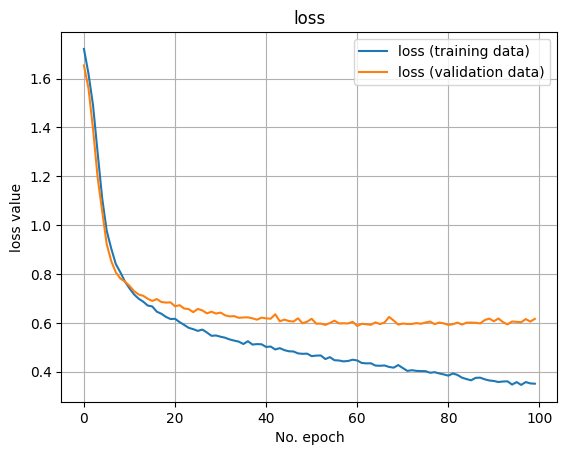

In [ ]:
plt.plot(history_1.history['loss'], label='loss (training data)')
plt.plot(history_1.history['val_loss'], label='loss (validation data)')
plt.title('loss')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()

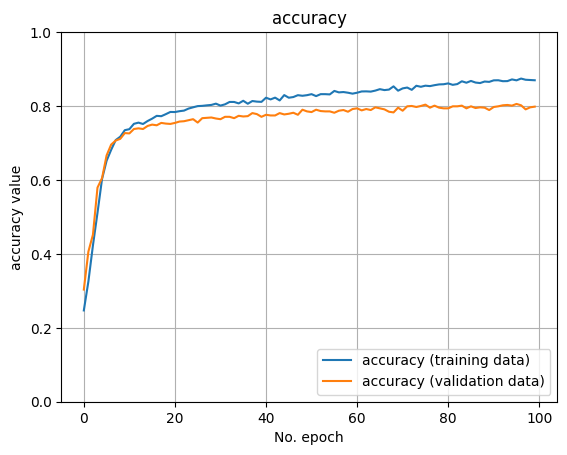

In [ ]:
plt.plot(history_1.history['accuracy'], label='accuracy (training data)')
plt.plot(history_1.history['val_accuracy'], label='accuracy (validation data)')
plt.title('accuracy')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
from keras import backend as K
epochs = 100 

history_2 = model_1_2.fit(X_train, y_train_main, batch_size=batch_size, epochs=epochs, validation_split = 0.2 ) #validation_data = (x_val, y_val))

Epoch 1/100
137/137 [==============================] - 3s 9ms/step - loss: 1.7742 - accuracy: 0.1795 - val_loss: 1.7438 - val_accuracy: 0.1861
Epoch 2/100
137/137 [==============================] - 1s 7ms/step - loss: 1.7247 - accuracy: 0.2220 - val_loss: 1.7000 - val_accuracy: 0.2071
Epoch 3/100
137/137 [==============================] - 1s 8ms/step - loss: 1.6868 - accuracy: 0.2470 - val_loss: 1.6672 - val_accuracy: 0.2392
Epoch 4/100
137/137 [==============================] - 1s 7ms/step - loss: 1.6571 - accuracy: 0.2628 - val_loss: 1.6400 - val_accuracy: 0.2640
Epoch 5/100
137/137 [==============================] - 1s 6ms/step - loss: 1.6295 - accuracy: 0.2875 - val_loss: 1.6126 - val_accuracy: 0.3016
Epoch 6/100
137/137 [==============================] - 1s 9ms/step - loss: 1.5995 - accuracy: 0.3249 - val_loss: 1.5785 - val_accuracy: 0.3456
Epoch 7/100
137/137 [==============================] - 1s 6ms/step - loss: 1.5614 - accuracy: 0.3671 - val_loss: 1.5341 - val_accuracy: 0.3877

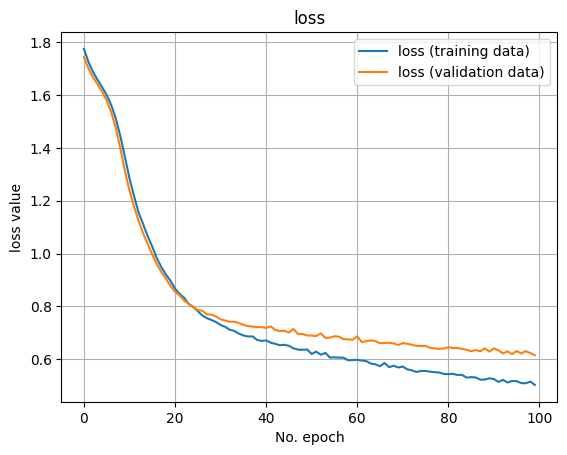

In [ ]:
plt.plot(history_2.history['loss'], label='loss (training data)')
plt.plot(history_2.history['val_loss'], label='loss (validation data)')
plt.title('loss')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()

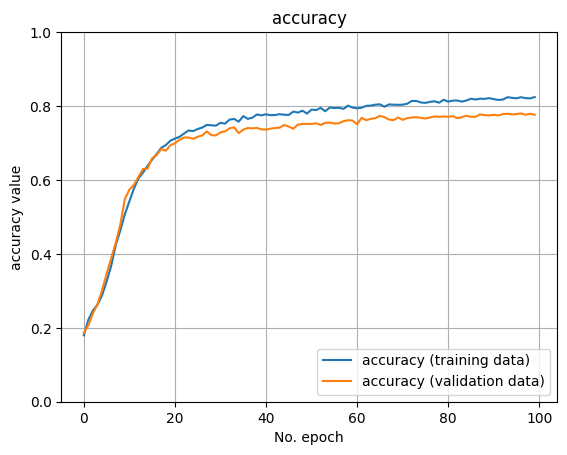

In [ ]:
plt.plot(history_2.history['accuracy'], label='accuracy (training data)')
plt.plot(history_2.history['val_accuracy'], label='accuracy (validation data)')
plt.title('accuracy')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
y_pred = model_1_1.predict(X_test)
y_test_label = np.array([np.argmax(y) for y in y_test_main])
y_pred_label = np.array([np.argmax(y) for y in y_pred])

y_pred_1 = model_1_2.predict(X_test)
y_test_label_1 = np.array([np.argmax(y) for y in y_test_main])
y_pred_label_1 = np.array([np.argmax(y) for y in y_pred])

16/16 [==============================] - 0s 2ms/step


In [ ]:
from sklearn.metrics import classification_report
class_names=['0', '1' , '2' , '3' , '4' , '5']

print(classification_report(y_test_label,y_pred_label,target_names = class_names))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       138
           1       0.86      0.63      0.72        94
           2       1.00      0.78      0.88         9
           3       0.91      0.91      0.91        65
           4       0.95      0.85      0.90       113
           5       0.86      0.86      0.86        81

    accuracy                           0.85       500
   macro avg       0.89      0.83      0.85       500
weighted avg       0.86      0.85      0.85       500



In [ ]:
from sklearn.metrics import classification_report
class_names=['0', '1' , '2' , '3' , '4' , '5']

print(classification_report(y_test_label_1,y_pred_label_1,target_names = class_names))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       138
           1       0.86      0.63      0.72        94
           2       1.00      0.78      0.88         9
           3       0.91      0.91      0.91        65
           4       0.95      0.85      0.90       113
           5       0.86      0.86      0.86        81

    accuracy                           0.85       500
   macro avg       0.89      0.83      0.85       500
weighted avg       0.86      0.85      0.85       500



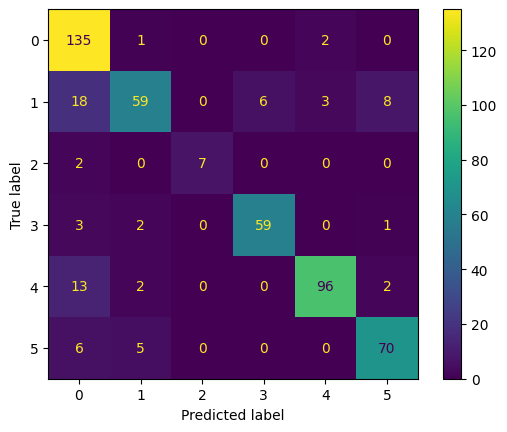

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


class_names=['0', '1' , '2' , '3' , '4' , '5']


from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_test_label, y_pred_label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)

cm_display.plot()
plt.show()

### Second Model

In [ ]:
from keras.layers import Lambda
import keras.backend as K

embedding_size = 300

lstm_units = 64

num_main_classes = 6

num_sub_classes = 47

def extract_timesteps(x):
    second_last = x[:, -2, :]
    last = x[:, -1, :]
    return [second_last, last]

shape=(seq_length_train,)

input_layer = Input(shape = shape, dtype='int32')

embedding_layer = Embedding(vocab_size, embedding_size ,weights=[embedding_matrix])(input_layer)

lstm_layer = LSTM(lstm_units, return_sequences=True)(embedding_layer)

second_last, last = Lambda(extract_timesteps)(lstm_layer)

main_output = Dense(num_main_classes, activation='softmax')(second_last)

sub_output = Dense(num_sub_classes, activation='softmax')(last)

model_2 = Model(inputs=input_layer, outputs=[main_output, sub_output])

model_2.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opt, metrics=['accuracy'])

model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 33, 300)      30000000    ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 33, 64)       93440       ['embedding_1[0][0]']            
                                                                                                  
 lambda (Lambda)                [(None, 64),         0           ['lstm_1[0][0]']                 
                                 (None, 64)]                                                  

In [ ]:
history_2 = model_2.fit(X_train, [y_train_main, y_train_sub], batch_size=batch_size, epochs=50, validation_split = 0.2)

Epoch 1/50
137/137 [==============================] - 3s 25ms/step - loss: 3.3210 - dense_12_loss: 0.9166 - dense_13_loss: 2.4044 - dense_12_accuracy: 0.7147 - dense_13_accuracy: 0.4389 - val_loss: 3.4116 - val_dense_12_loss: 0.9769 - val_dense_13_loss: 2.4347 - val_dense_12_accuracy: 0.6645 - val_dense_13_accuracy: 0.4244
Epoch 2/50
137/137 [==============================] - 3s 22ms/step - loss: 3.1974 - dense_12_loss: 0.8636 - dense_13_loss: 2.3337 - dense_12_accuracy: 0.7342 - dense_13_accuracy: 0.4540 - val_loss: 3.3323 - val_dense_12_loss: 0.9509 - val_dense_13_loss: 2.3814 - val_dense_12_accuracy: 0.6774 - val_dense_13_accuracy: 0.4280
Epoch 3/50
137/137 [==============================] - 3s 22ms/step - loss: 3.0849 - dense_12_loss: 0.8152 - dense_13_loss: 2.2697 - dense_12_accuracy: 0.7521 - dense_13_accuracy: 0.4639 - val_loss: 3.2383 - val_dense_12_loss: 0.9126 - val_dense_13_loss: 2.3257 - val_dense_12_accuracy: 0.6920 - val_dense_13_accuracy: 0.4317
Epoch 4/50
137/137 [=====

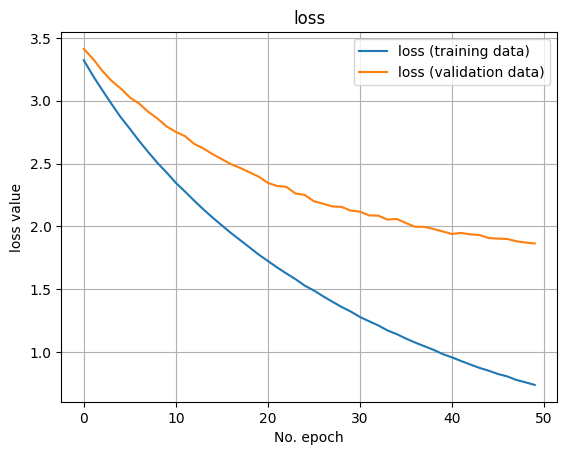

In [ ]:
plt.plot(history_2.history['loss'], label='loss (training data)')
plt.plot(history_2.history['val_loss'], label='loss (validation data)')
plt.title('loss')
plt.ylabel('loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.grid()
plt.show()

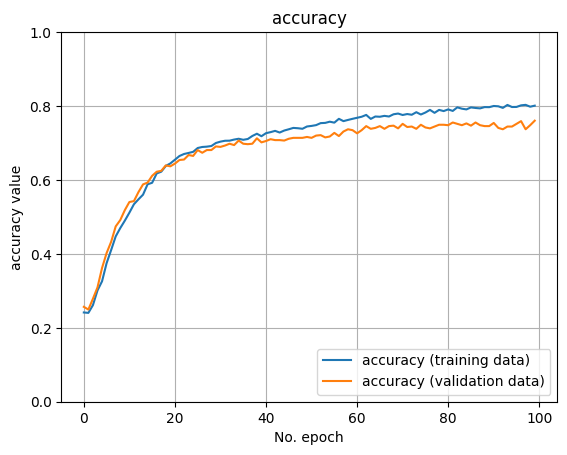

In [ ]:
plt.plot(history_1.history['accuracy'], label='accuracy (training data)')
plt.plot(history_1.history['val_accuracy'], label='accuracy (validation data)')
plt.title('accuracy')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
y_pred = model_1.predict(X_test)
y_test_label =np.array([np.argmax(y) for y in y_test_main])
y_pred_label = np.array([np.argmax(y) for y in y_pred])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_c,y_pred_c,target_names=['Meningioma', 'Glioma' , 'Pituitary']))


In [9]:
X_a_oneHot = to_categorical(X_a)


### Third Model:

In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [46]:
def scheduler(epoch, lr):
  if epoch % 100 != 0:
    return lr
  else:
    return lr/2

In [47]:
# del model
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional

input_text = Input(shape=(seq_length_Q,), dtype='int32')

embedding_size = 300
embedded_text = Embedding(input_dim=vocab_size, output_dim=embedding_size, weights=[embedding_matrix], trainable=False)(input_text)

lstm_out = LSTM(300, return_state=True)(embedded_text)

_, h, c = lstm_out

forward_h = h
forward_c = c
backward_h = h
backward_c = c

label_states = [forward_h,forward_c,backward_h,backward_c]
blstm_out = Bidirectional(LSTM(300, return_sequences=True))(embedded_text, initial_state = label_states)
dense_out = Dense(1024, activation='relu')(blstm_out)
dense_out_2 = Dense(2048, activation='relu')(dense_out)
output = Dense(X_a_oneHot.shape[2], activation='softmax')(dense_out_2)

model = Model(inputs=input_text, outputs=output)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 16, 300)      30000000    ['input_9[0][0]']                
                                                                                                  
 lstm_17 (LSTM)                 [(None, 300),        721200      ['embedding_9[0][0]']            
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                            

In [48]:
history_4 = model.fit(X_q,X_a_oneHot ,batch_size=batch_size, callbacks=[callback], epochs=200)

Epoch 1/200
16/16 [==============================] - 32s 45ms/step - loss: 2.7325 - accuracy: 0.8506 - lr: 0.0050
Epoch 2/200
16/16 [==============================] - 1s 38ms/step - loss: 0.8211 - accuracy: 0.9079 - lr: 0.0050
Epoch 3/200
16/16 [==============================] - 1s 37ms/step - loss: 0.7199 - accuracy: 0.9079 - lr: 0.0050
Epoch 4/200
16/16 [==============================] - 1s 38ms/step - loss: 0.6753 - accuracy: 0.9080 - lr: 0.0050
Epoch 5/200
16/16 [==============================] - 1s 37ms/step - loss: 0.6409 - accuracy: 0.9080 - lr: 0.0050
Epoch 6/200
16/16 [==============================] - 1s 37ms/step - loss: 0.6288 - accuracy: 0.9078 - lr: 0.0050
Epoch 7/200
16/16 [==============================] - 1s 37ms/step - loss: 0.6027 - accuracy: 0.9071 - lr: 0.0050
Epoch 8/200
16/16 [==============================] - 1s 46ms/step - loss: 0.5901 - accuracy: 0.9078 - lr: 0.0050
Epoch 9/200
16/16 [==============================] - 1s 46ms/step - loss: 0.5578 - accuracy: 0.

In [60]:
test_1 = ['how many people speak french?']
test_2 = ['what day is today?']
test_3 = ['who will win the war?']
test_4 = ['who is italian war minister?']
test_5 = ['when world war ii ended?']
test_6 = ['when was gandhi assassinated?']
''''''
tokenized_1 = tokenizer.texts_to_sequences(test_1)
tokenized_2 = tokenizer.texts_to_sequences(test_2)
tokenized_3 = tokenizer.texts_to_sequences(test_3)
tokenized_4 = tokenizer.texts_to_sequences(test_4)
tokenized_5 = tokenizer.texts_to_sequences(test_5)
tokenized_6 = tokenizer.texts_to_sequences(test_6)
''''''

padded_test_1 = pad_sequences(tokenized_1, maxlen=seq_length_Q, padding = 'pre')
padded_test_2 = pad_sequences(tokenized_2, maxlen=seq_length_Q, padding = 'pre')
padded_test_3 = pad_sequences(tokenized_3, maxlen=seq_length_Q, padding = 'pre')
padded_test_4 = pad_sequences(tokenized_4, maxlen=seq_length_Q, padding = 'pre')
padded_test_5 = pad_sequences(tokenized_5, maxlen=seq_length_Q, padding = 'pre')
padded_test_6 = pad_sequences(tokenized_6, maxlen=seq_length_Q, padding = 'pre')


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           7,   19,   47, 1628,  233]], dtype=int32)

In [74]:
X_pred_1 = model.predict(padded_test_1)
X_pred_2 = model.predict(padded_test_2)
X_pred_3 = model.predict(padded_test_3)
X_pred_4 = model.predict(padded_test_4)
X_pred_5 = model.predict(padded_test_5)
X_pred_6 = model.predict(padded_test_6)

1/1 [==============================] - 0s 22ms/step


In [75]:
answer_1 = tokenizer.sequences_to_texts(X_pred_1.argmax(axis=2))
answer_2 = tokenizer.sequences_to_texts(X_pred_2.argmax(axis=2))
answer_3 = tokenizer.sequences_to_texts(X_pred_3.argmax(axis=2))
answer_4 = tokenizer.sequences_to_texts(X_pred_4.argmax(axis=2))
answer_5 = tokenizer.sequences_to_texts(X_pred_5.argmax(axis=2))
answer_6 = tokenizer.sequences_to_texts(X_pred_6.argmax(axis=2))

In [83]:
tableQA = {test_1[0]:answer_1 , test_2[0]:answer_2 , test_3[0]:answer_3 , test_4[0]:answer_4  ,
           test_5[0]:answer_5 , test_6[0]:answer_6}

In [87]:
import pandas as pd
tableQA
QATable = pd.DataFrame(tableQA)

In [89]:
QATable.transpose()

,0
how many people speak french?,
what day is today?,
who will win the war?,park
who is italian war minister?,
when world war ii ended?,
when was gandhi assassinated?,16th us president


In [115]:
QATable

,how many people speak french?,what day is today?,who will win the war?,who is italian war minister?,when world war ii ended?,when was gandhi assassinated?
0,,,park,,,16th us president


### Sample Questions from traing

In [136]:
X_pred = model.predict(np.expand_dims(X_q[25], axis=0))
answer_pred = tokenizer.sequences_to_texts(X_pred.argmax(axis=2))

1/1 [==============================] - 0s 25ms/step


In [139]:
train_eval = {'Question' : Questions[25] , 'True Answer': Answers[25] , 'Predicted Answer':answer_pred}
train_eval = pd.DataFrame(train_eval)
train_eval.transpose()

,0
Question,who developed the macintosh computer ?
True Answer,steve jobs
Predicted Answer,steve jobs


In [142]:
X_pred = model.predict(np.expand_dims(X_q[6], axis=0))
answer_pred = tokenizer.sequences_to_texts(X_pred.argmax(axis=2))

1/1 [==============================] - 0s 45ms/step


In [143]:
train_eval = {'Question' : Questions[6] , 'True Answer': Answers[6] , 'Predicted Answer':answer_pred}
train_eval = pd.DataFrame(train_eval)
train_eval.transpose()

,0
Question,george bush purchased a small interest in whic...
True Answer,texas rangers
Predicted Answer,texas


In [ ]:
X_pred = model.predict(np.expand_dims(X_q[10], axis=0))
answer_pred = tokenizer.sequences_to_texts(X_pred.argmax(axis=2))

In [145]:
train_eval = {'Question' : Questions[10] , 'True Answer': Answers[10] , 'Predicted Answer':answer_pred}
train_eval = pd.DataFrame(train_eval)
train_eval.transpose()

,0
Question,what city had a world fair in 1900 ?
True Answer,paris
Predicted Answer,paris
